In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from torchvision import transforms, datasets

We will implement a convolutional denoising autoencoder (C-DAE) with 3 convolutional layers on each side of the bottleneck.  
The C-DAE will be trained against $\mathcal{N}\left(0,\ 0.03\right)$ perturbations.

In [2]:
class ConvDAE(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),   # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
        
    def forward(self, x):
        return self.decode(self.encode(x))
    
    def training_step(self, batch, batch_nb=None):
        x, _ = batch
        noise = torch.randn_like(x)
        x_distorted = x + 3e-2 * noise
        x_rec = self.forward(x_distorted)
        loss = F.binary_cross_entropy(x_rec, x)
        self.log('loss', loss, logger=True)
        return loss
    
    def validation_step(self, batch, batch_nb):
        return self.training_step(batch)
    
    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack(outputs).mean()
        self.log('val_loss', avg_val_loss, prog_bar=True)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

Load the CIFAR-10 dataset using `torchvision`.

In [3]:
train_dataset = datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transforms.ToTensor()
)
val_dataset = datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


Train the model for 100 epochs.

In [ ]:
trainer = pl.Trainer(
    gpus=1, max_epochs=100,
    logger=pl.loggers.CSVLogger('.', 'logs', 0)
)

model = ConvDAE()
train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True, num_workers=5)
val_dataloader = DataLoader(val_dataset, batch_size=500)

trainer.fit(model, train_dataloader=train_dataloader, val_dataloaders=val_dataloader)

Display the learning curves.

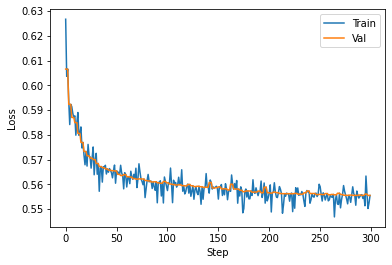

In [5]:
log = pd.read_csv('logs/version_0/metrics.csv').fillna(method='backfill')

plt.plot(log.loss, label='Train')
plt.plot(log.val_loss, label='Val')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

Implement a function for displaying images represented as tensors and a function that applies C-DAE to a given image.

In [8]:
def as_img(tensor):
    return plt.imshow(transforms.functional.to_pil_image(tensor))

def denoise(model, tensor):
    return model.forward(tensor.unsqueeze(0)).squeeze(0)

Let's see how our model works. Firstly, we will choose one image and obtain a noised version of it.

In [9]:
img = val_dataset[7][0]
img_noised = img + 3e-2 * torch.randn_like(img)

Original image:

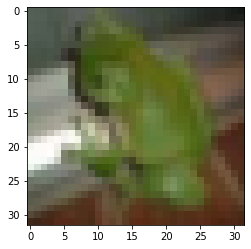

In [10]:
as_img(img)

Corrupted image:

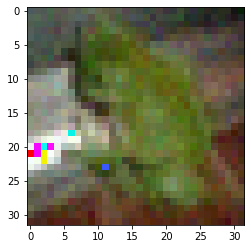

In [11]:
as_img(img_noised)

Denoising of the original image:

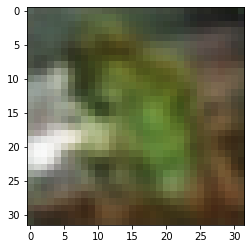

In [12]:
as_img(denoise(model, img))

Denoising of the corrupted image:

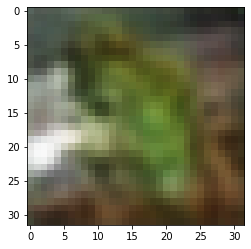

In [13]:
as_img(denoise(model, img_noised))